# Modelo modificado de la Double-UNet en el conjunto de datos CVCClinicDB

In [41]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd

import json
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# **Utility functions**
Funciones para crear directorios, cargar o leer imagenes o parámetros de modelos preentrenados.

In [42]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(impath, mskpath):
    """ Read the image and mask from the given path. """
    image = cv2.imread(impath, cv2.IMREAD_COLOR)
    mask = cv2.imread(mskpath, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data_(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [43]:
def load_model_weight(path):
    with ObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

# **Model**

Se redujo el número de filtros en el decoder de la primera red (decoder1) y de la segunda red (decoder2) y del encoder de la segunda red (encoder2).
![](https://raw.githubusercontent.com/DebeshJha/2020-CBMS-DoubleU-Net/master/img/DoubleU-Net.png)

In [44]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
#     num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
#     num_filters = [32, 64, 128, 256]
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
#     num_filters = [256, 128, 64, 32]
    num_filters = [128, 64, 32, 16]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

# **Metrics (metrics.py)**

In [45]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

# **Predict**

In [70]:
def read_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred

def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        
        x=tf.expand_dims(x, axis=0, name=None)
        _, h, w, _ = x.shape
        
        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])
        
        line = np.ones((h, 10, 3)) * 255.0
        
        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)

        cv2.imwrite(f"results/{i}.png", mask)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def features_labels(featFiles, labFiles):
    features = []
    labels = []
    for img, mask in zip(featFiles, labFiles):
        x,y = parse_data(img, mask)
        features.append(x)
        labels.append(y)
    features = tf.constant(features)
    labels = tf.constant(labels)
    return features, labels

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y
    x, y = _parse(x, y)
    x=x.reshape([192, 256, 3])
    y=y.reshape([192, 256, 2])
    return x, y

def tf_dataset(featFiles, labFiles, batch=16):
#     features, labels = features_labels(featFiles, labFiles)
    dataset = tf.data.Dataset.from_tensor_slices((features_labels(featFiles, labFiles)))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

# Training

In [32]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")

model_path = "files/model.h5"
batch_size = 16
epochs = 100
lr = 1e-5
shape = (192, 256, 3)

train_path = "/kaggle/input/trainingresultsdeeplearningfinalproject/new_data/train"
valid_path = "/kaggle/input/trainingresultsdeeplearningfinalproject/new_data/valid"

## Training
train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

## Shuffling
train_x, train_y = shuffling(train_x, train_y)

## Validation
valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

model = build_model(shape)
metrics = [
    dice_coef,
    iou,
    Recall(),
    Precision()
]

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model.compile(loss=binary_crossentropy, optimizer=Nadam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
    CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1


2022-12-03 19:25:47.510142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067084800 exceeds 10% of free system memory.
2022-12-03 19:31:12.914829: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2044723200 exceeds 10% of free system memory.
2022-12-03 19:36:18.266503: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067084800 exceeds 10% of free system memory.
2022-12-03 19:36:20.851922: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2044723200 exceeds 10% of free system memory.
2022-12-03 19:36:30.053405: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 19:36:30.053460: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-03 19:36:30.305420: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 19:36:30.305642: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI

In [33]:
model.fit(train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        shuffle=False)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-03 19:36:30.608644: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067084800 exceeds 10% of free system memory.


Epoch 1/100


2022-12-03 19:36:48.726863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-03 19:36:55.013062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-03 19:37:08.983734: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-03 19:37:08.983850: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/325 [..............................] - ETA: 3:34:46 - loss: 0.7914 - dice_coef: 0.1516 - iou: 0.0820 - recall_4: 0.5953 - precision_4: 0.0924

2022-12-03 19:37:16.708749: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 19:37:16.708797: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/325 [..............................] - ETA: 11:45 - loss: 0.7996 - dice_coef: 0.1604 - iou: 0.0872 - recall_4: 0.5315 - precision_4: 0.0891  

2022-12-03 19:37:18.189031: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 19:37:18.194803: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 19:37:18.471601: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5453 callback api events and 5447 activity events. 
2022-12-03 19:37:18.663012: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 19:37:18.958473: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_03_19_37_18

2022-12-03 19:37:19.086143: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_03_19_37_18/ede5ef1e51b6.trace.json.gz
2022-12-03 19:37:19.325035: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

325/325 [==============================] - 271s 715ms/step - loss: 0.6445 - dice_coef: 0.2231 - iou: 0.1265 - recall_4: 0.7273 - precision_4: 0.2217 - val_loss: 0.5941 - val_dice_coef: 0.1665 - val_iou: 0.0909 - val_recall_4: 0.3306 - val_precision_4: 0.1966
Epoch 2/100
325/325 [==============================] - 229s 706ms/step - loss: 0.4627 - dice_coef: 0.3189 - iou: 0.1905 - recall_4: 0.8022 - precision_4: 0.7578 - val_loss: 0.4319 - val_dice_coef: 0.2974 - val_iou: 0.1760 - val_recall_4: 0.7484 - val_precision_4: 0.8748
Epoch 3/100
325/325 [==============================] - 229s 705ms/step - loss: 0.4062 - dice_coef: 0.3559 - iou: 0.2175 - recall_4: 0.8393 - precision_4: 0.8926 - val_loss: 0.4013 - val_dice_coef: 0.3439 - val_iou: 0.2084 - val_recall_4: 0.8524 - val_precision_4: 0.8659
Epoch 4/100
325/325 [==============================] - 229s 705ms/step - loss: 0.3783 - dice_coef: 0.3753 - iou: 0.2321 - recall_4: 0.8539 - precision_4: 0.9386 - val_loss: 0.3887 - val_dice_coef: 0.

In [ ]:
import shutil
shutil.make_archive('files', 'zip', '/kaggle/working/files')

# Metrics

In [4]:
metrics_trn = pd.read_csv("/kaggle/input/trainingresultsdeeplearningfinalproject/Training results/ModifiedDoubleUnet/data.csv")  
metrics_trn = metrics_trn.set_index('epoch')
metrics_trn.head(10)

,dice_coef,iou,loss,lr,precision_4,recall_4,val_dice_coef,val_iou,val_loss,val_precision_4,val_recall_4
epoch,,,,,,,,,,,
0,0.223063,0.126523,0.644478,0.00001,0.221714,0.727283,0.166535,0.090906,0.594057,0.196550,0.330590
1,0.318850,0.190533,0.462724,0.00001,0.757771,0.802231,0.297433,0.175996,0.431930,0.874772,0.748365
2,0.355864,0.217461,0.406169,0.00001,0.892553,0.839260,0.343938,0.208426,0.401324,0.865855,0.852397
3,0.375318,0.232087,0.378281,0.00001,0.938632,0.853925,0.343128,0.207191,0.388651,0.918895,0.802769
4,0.387893,0.241737,0.359505,0.00001,0.952836,0.860882,0.333789,0.201114,0.377315,0.940357,0.765880
5,0.399430,0.250775,0.343310,0.00001,0.960824,0.869143,0.362094,0.221207,0.371191,0.904723,0.830033
6,0.409745,0.258942,0.329287,0.00001,0.966346,0.875115,0.367568,0.225931,0.364418,0.892679,0.836683
7,0.419403,0.266619,0.317113,0.00001,0.970061,0.880071,0.366326,0.225944,0.348303,0.930619,0.791205
8,0.427377,0.273141,0.306327,0.00001,0.970222,0.880227,0.371735,0.228755,0.339101,0.924110,0.787474


Text(0.5, 1.0, 'Precisión')

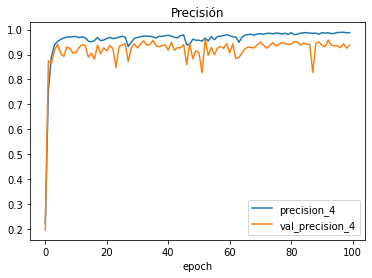

In [6]:
lines = metrics_trn[["precision_4","val_precision_4"]].plot.line()
plt.title("Precisión")

Text(0.5, 1.0, 'Recall')

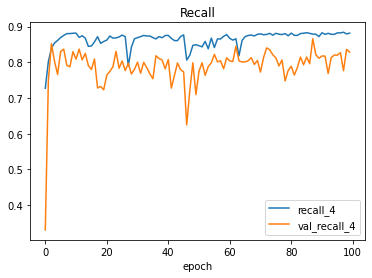

In [7]:
lines = metrics_trn[["recall_4","val_recall_4"]].plot.line()
plt.title("Recall")

# Predict

In [35]:
## Training
test_path = "/kaggle/input/trainingresultsdeeplearningfinalproject/new_data/test"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))


In [71]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("results/")
m = load_model_weight("/kaggle/input/trainingresultsdeeplearningfinalproject/training_results/Training results/ModifiedDoubleUnet/model.h5")
evaluate_normal(m, test_x, test_y)

100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


In [97]:
import shutil
shutil.make_archive("results", 'zip', "/kaggle/working/results")

'/kaggle/working/results.zip'

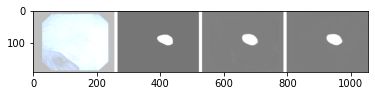

In [109]:
results = "/kaggle/working/results"
test = sorted(glob(results+'/*'))
x = read_image(test[15])
plt.imshow(x,cmap='viridis',vmin=x.min(), vmax=x.max())
plt.show()